In [1]:
!pip install gtsam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.1/27.1 MB 53.7 MB/s eta 0:00:00


In [2]:
!wget https://raw.githubusercontent.com/egeozgul/GTSAM-Project/main/grid3D.g2o

--2025-12-02 21:10:31--  https://raw.githubusercontent.com/egeozgul/GTSAM-Project/main/grid3D.g2o
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7645820 (7.3M) [text/plain]
Saving to: ‘grid3D.g2o’

grid3D.g2o          100%[===================>]   7.29M  --.-KB/s    in 0.03s   

2025-12-02 21:10:31 (240 MB/s) - ‘grid3D.g2o’ saved [7645820/7645820]



In [3]:
!wget https://raw.githubusercontent.com/egeozgul/GTSAM-Project/main/sphere_bignoise_vertex3.g2o

--2025-12-02 21:10:31--  https://raw.githubusercontent.com/egeozgul/GTSAM-Project/main/sphere_bignoise_vertex3.g2o
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2221712 (2.1M) [text/plain]
Saving to: ‘sphere_bignoise_vertex3.g2o’

sphere_bignoise_ver 100%[===================>]   2.12M  --.-KB/s    in 0.02s   

2025-12-02 21:10:31 (136 MB/s) - ‘sphere_bignoise_vertex3.g2o’ saved [2221712/2221712]



In [4]:
!wget https://raw.githubusercontent.com/egeozgul/GTSAM-Project/main/torus3D.g2o

--2025-12-02 21:10:31--  https://raw.githubusercontent.com/egeozgul/GTSAM-Project/main/torus3D.g2o
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3262828 (3.1M) [text/plain]
Saving to: ‘torus3D.g2o’

torus3D.g2o         100%[===================>]   3.11M  --.-KB/s    in 0.02s   

2025-12-02 21:10:31 (176 MB/s) - ‘torus3D.g2o’ saved [3262828/3262828]



In [6]:
import gtsam

# Dictionary to store all loaded graphs
graphs_3d = {}

# List of files to load
files_3d = [
    "grid3D.g2o",
    "sphere_bignoise_vertex3.g2o",
    "torus3D.g2o"
]

print("Loading 3D graph files...")
print("="*60)

for filename in files_3d:
    print(f"\nLoading {filename}...")

    try:
        # Load 3D graph
        graph, initial = gtsam.readG2o(filename, is3D=True)

        graphs_3d[filename] = {
            'graph': graph,
            'initial': initial,
            'num_factors': graph.size(),
            'num_poses': initial.size()
        }

        print(f"  ✓ Loaded successfully")
        print(f"    - Factors: {graph.size()}")
        print(f"    - Poses: {initial.size()}")
        print(f"    - Initial error: {graph.error(initial):,.2f}")

    except Exception as e:
        print(f"  ✗ Failed to load: {e}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
for filename, data in graphs_3d.items():
    print(f"\n{filename}:")
    print(f"  Factors: {data['num_factors']}")
    print(f"  Poses: {data['num_poses']}")
    print(f"  Initial error: {data['graph'].error(data['initial']):,.2f}")

Loading 3D graph files...

Loading grid3D.g2o...
  ✓ Loaded successfully
    - Factors: 22236
    - Poses: 8000
    - Initial error: 95,280,764.18

Loading sphere_bignoise_vertex3.g2o...
  ✓ Loaded successfully
    - Factors: 8647
    - Poses: 2200
    - Initial error: 165,629,548.02

Loading torus3D.g2o...
  ✓ Loaded successfully
    - Factors: 9048
    - Poses: 5000
    - Initial error: 2,400,615.02

SUMMARY

grid3D.g2o:
  Factors: 22236
  Poses: 8000
  Initial error: 95,280,764.18

sphere_bignoise_vertex3.g2o:
  Factors: 8647
  Poses: 2200
  Initial error: 165,629,548.02

torus3D.g2o:
  Factors: 9048
  Poses: 5000
  Initial error: 2,400,615.02


# **Applying ISAM2 on all 3 datasets**

In [14]:
print("="*60)
print("APPLYING ISAM2 TO ALL DATASETS")
print("="*60)


import gtsam
import time
import numpy as np

# Dictionary to store results for ISAM2
results_isam2 = {}

datasets = ['grid3D.g2o', 'sphere_bignoise_vertex3.g2o', 'torus3D.g2o']

for dataset_name in datasets:
    print(f"\n{'='*60}")
    print(f"Processing: {dataset_name}")
    print(f"{'='*60}")

    graph = graphs_3d[dataset_name]['graph']
    initial = graphs_3d[dataset_name]['initial']

    print(f"Poses: {initial.size()}, Factors: {graph.size()}")
    print(f"Initial error: {graph.error(initial):,.2f}")

    # Optimize with ISAM2
    print("\nOptimizing with ISAM2...")
    start_time = time.time()

    try:
        # Create a copy of the graph and add a prior on the first pose
        graph_with_prior = gtsam.NonlinearFactorGraph(graph)

        # Get the first key from initial estimates
        keys = list(initial.keys())
        first_key = keys[0] if len(keys) > 0 else 0

        # Add a strong prior on the first pose to anchor the solution
        first_pose = initial.atPose3(first_key)
        prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01]))
        prior_factor = gtsam.PriorFactorPose3(first_key, first_pose, prior_noise)
        graph_with_prior.add(prior_factor)

        print(f"Added prior on pose {first_key} to anchor the coordinate frame")

        # Create ISAM2 parameters
        params = gtsam.ISAM2Params()
        params.setRelinearizeThreshold(0.01)  # More aggressive relinearization
        params.relinearizeSkip = 1

        # Create ISAM2 optimizer
        isam = gtsam.ISAM2(params)

        # Add all factors and initial values to ISAM2
        isam.update(graph_with_prior, initial)

        # Perform additional update iterations to fully optimize
        print("Performing additional optimization iterations...")
        for i in range(5):
            isam.update()
            current_estimate = isam.calculateEstimate()
            current_error = graph.error(current_estimate)
            print(f"  Iteration {i+1}: Error = {current_error:,.2f}")

        # Get the final result
        result = isam.calculateEstimate()

        end_time = time.time()

        # Calculate errors using the original graph (without prior)
        final_error = graph.error(result)
        initial_error = graph.error(initial)
        improvement = ((initial_error - final_error) / initial_error * 100)

        # Store results
        results_isam2[dataset_name] = {
            'success': True,
            'initial': initial,
            'result': result,
            'graph': graph,
            'graph_with_prior': graph_with_prior,
            'initial_error': initial_error,
            'final_error': final_error,
            'improvement': improvement,
            'time': end_time - start_time,
            'isam': isam,
            'anchored_pose': first_key
        }

        print(f"✓ Optimization successful!")
        print(f"  Initial error: {initial_error:,.2f}")
        print(f"  Final error: {final_error:,.2f}")
        print(f"  Improvement: {improvement:.2f}%")
        print(f"  Time: {end_time - start_time:.4f}s")

    except Exception as e:
        results_isam2[dataset_name] = {
            'success': False,
            'initial': initial,
            'graph': graph,
            'error_message': str(e),
            'initial_error': graph.error(initial)
        }
        print(f"✗ ISAM2 failed: {str(e)}")

# Summary
print("\n" + "="*60)
print("SUMMARY - ISAM2")
print("="*60)
print(f"{'Dataset':<35} {'Status':<12} {'Initial Error':<18} {'Final Error':<18} {'Improvement':<12} {'Time':<10}")
print("-"*110)

for dataset_name in datasets:
    result = results_isam2[dataset_name]
    if result['success']:
        status = "✓ Success"
        initial_err = f"{result['initial_error']:,.2f}"
        final_err = f"{result['final_error']:,.2f}"
        improvement = f"{result['improvement']:.2f}%"
        time_str = f"{result['time']:.4f}s"
        print(f"{dataset_name:<35} {status:<12} {initial_err:<18} {final_err:<18} {improvement:<12} {time_str:<10}")
    else:
        status = "✗ Failed"
        initial_err = f"{result['initial_error']:,.2f}"
        print(f"{dataset_name:<35} {status:<12} {initial_err:<18} {'N/A':<18} {'N/A':<12} {'N/A':<10}")

print("\n" + "="*60)
successful_count = sum(1 for r in results_isam2.values() if r['success'])
print(f"Successfully optimized {successful_count}/{len(datasets)} datasets")
print("Results stored in 'results_isam2' dictionary")
print("Access individual results with: results_isam2['grid3D.g2o']")
print("="*60)

APPLYING ISAM2 TO ALL DATASETS

Processing: grid3D.g2o
Poses: 8000, Factors: 22236
Initial error: 95,280,764.18

Optimizing with ISAM2...
Added prior on pose 0 to anchor the coordinate frame
Performing additional optimization iterations...
  Iteration 1: Error = 495,013,263.34
  Iteration 2: Error = 234,473,244.24
  Iteration 3: Error = 129,442,884.73
  Iteration 4: Error = 50,025,874.30
  Iteration 5: Error = 18,558,119.29
✓ Optimization successful!
  Initial error: 95,280,764.18
  Final error: 18,558,119.29
  Improvement: 80.52%
  Time: 81.7192s

Processing: sphere_bignoise_vertex3.g2o
Poses: 2200, Factors: 8647
Initial error: 165,629,548.02

Optimizing with ISAM2...
Added prior on pose 0 to anchor the coordinate frame
Performing additional optimization iterations...
  Iteration 1: Error = 2,197,786,100.20
  Iteration 2: Error = 3,669,592,691.91
  Iteration 3: Error = 3,923,088,605.89
  Iteration 4: Error = 1,190,505,434.90
  Iteration 5: Error = 257,804,568.14
✓ Optimization success


Visualizing grid3D.g2o...


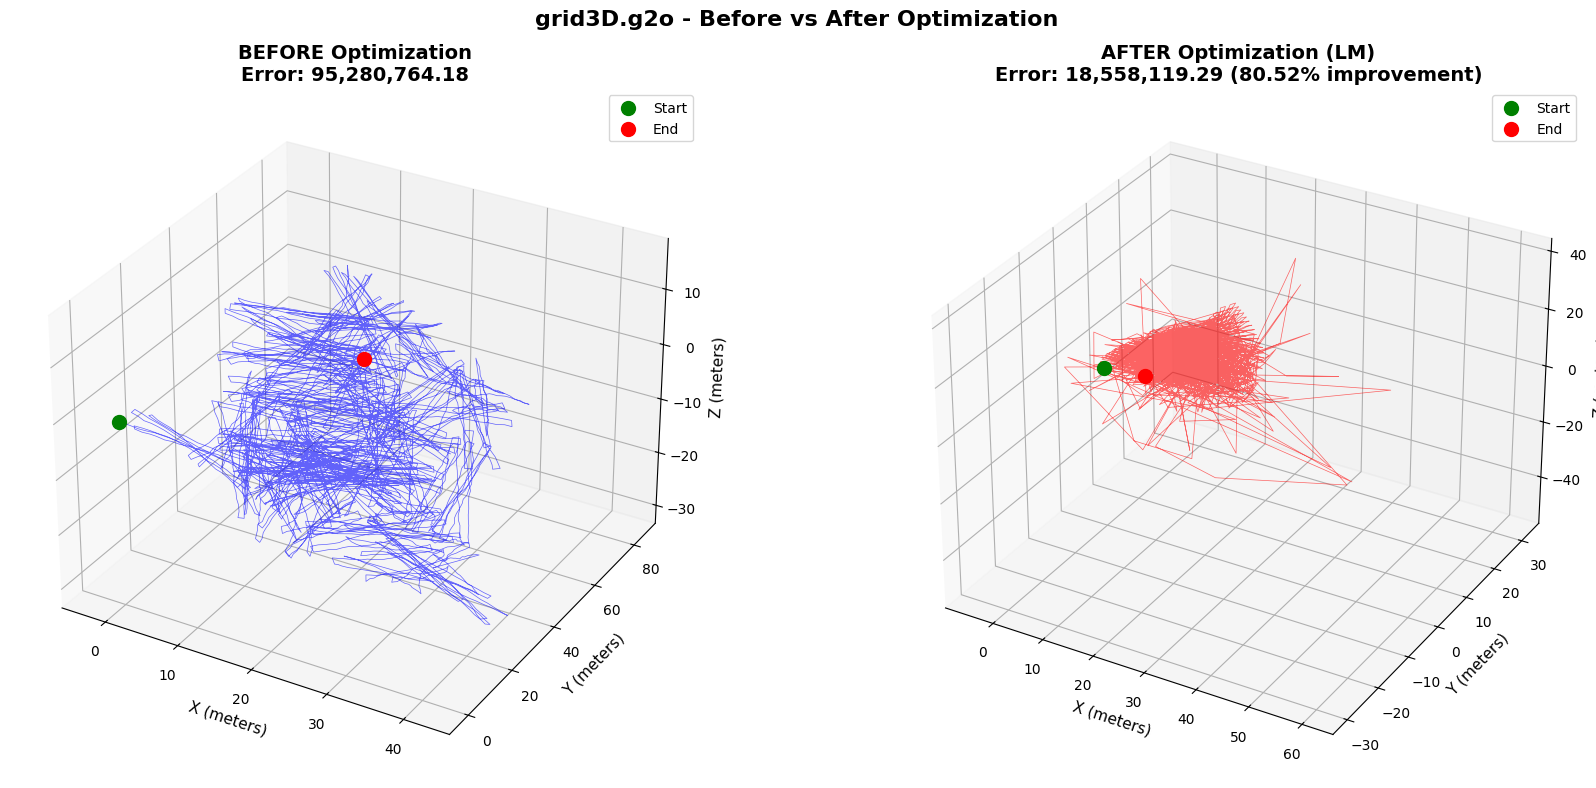


  Trajectory statistics for grid3D.g2o:
    Initial - X: [-2.77, 42.58], Y: [-2.01, 84.79], Z: [-30.11, 15.69]
    Optimized - X: [-4.88, 60.94], Y: [-30.03, 31.87], Z: [-50.63, 37.90]
    Initial trajectory length: 8,422.60 meters
    Optimized trajectory length: 12,961.29 meters
    Loop closure error (start-to-end distance):
      Initial: 86.39 meters
      Optimized: 8.56 meters
      Improvement: 77.83 meters

Visualizing sphere_bignoise_vertex3.g2o...


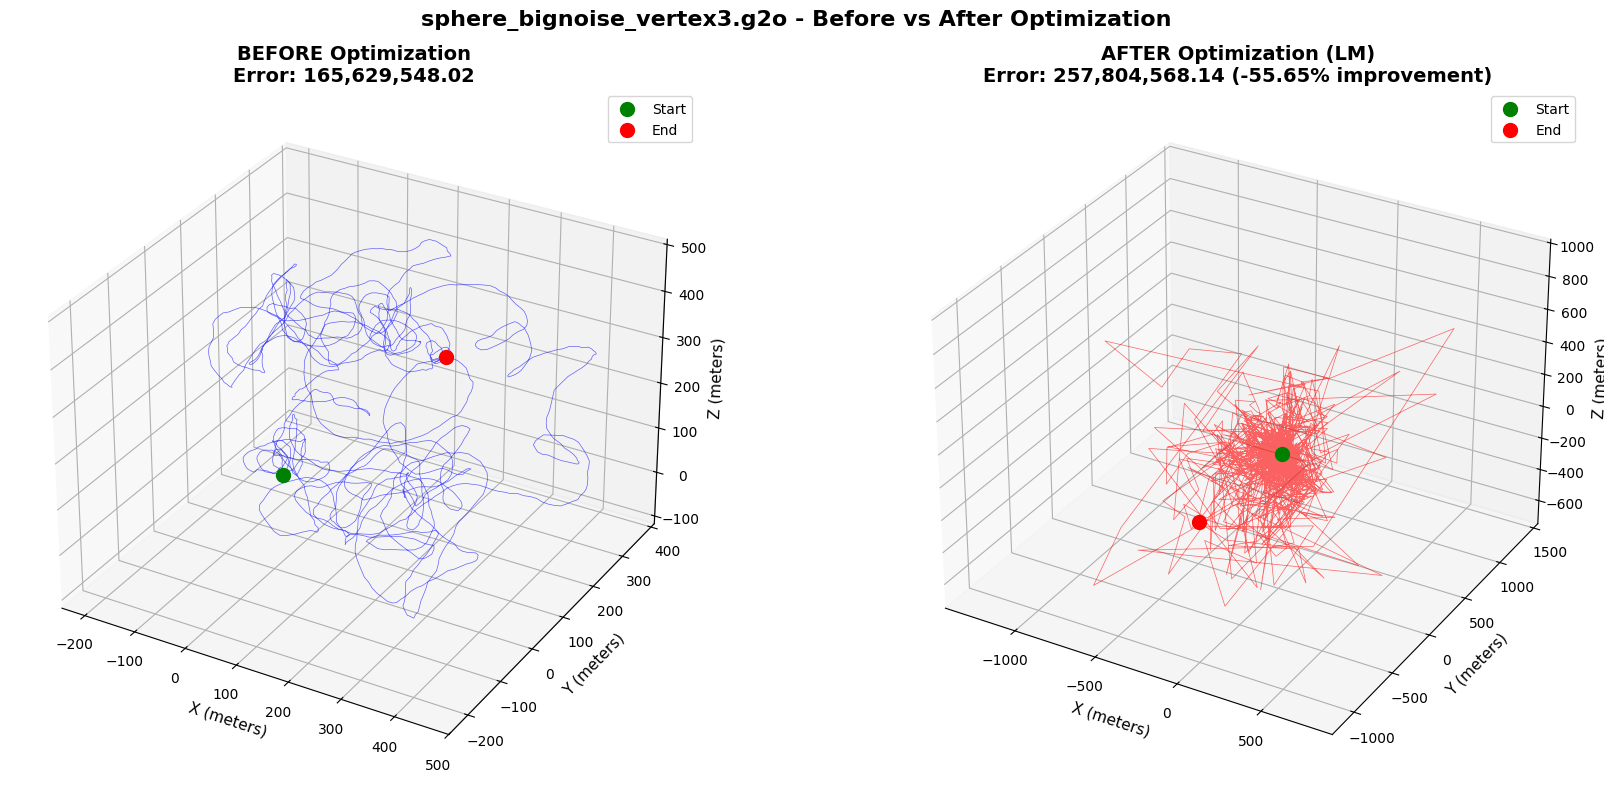


  Trajectory statistics for sphere_bignoise_vertex3.g2o:
    Initial - X: [-198.79, 452.90], Y: [-214.52, 369.30], Z: [-77.61, 471.31]
    Optimized - X: [-1292.16, 766.35], Y: [-1096.75, 1383.53], Z: [-636.27, 909.99]
    Initial trajectory length: 19,651.48 meters
    Optimized trajectory length: 224,463.10 meters
    Loop closure error (start-to-end distance):
      Initial: 362.41 meters
      Optimized: 882.38 meters
      Improvement: -519.97 meters

Visualizing torus3D.g2o...


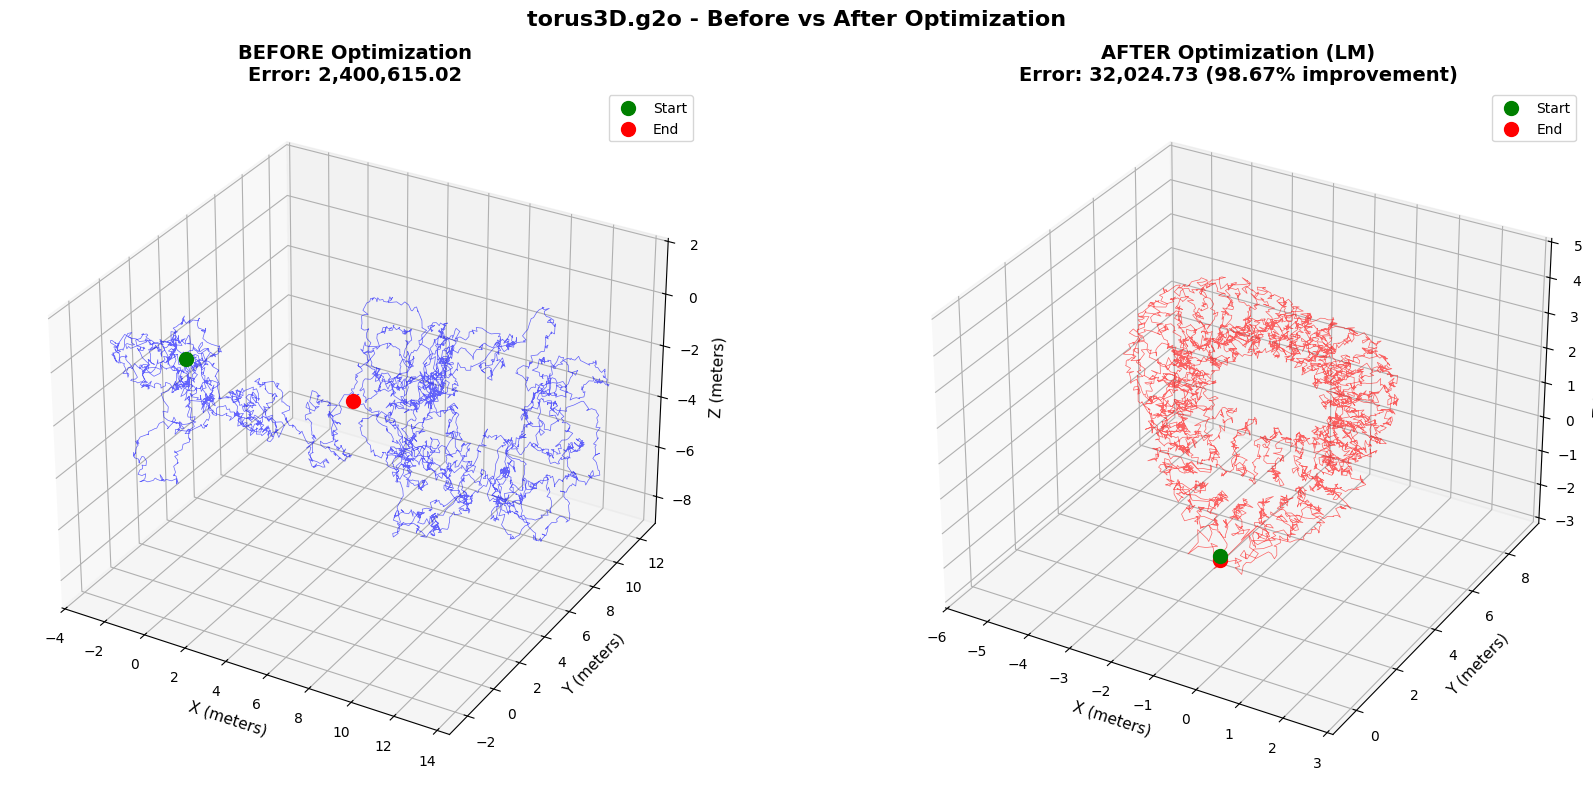


  Trajectory statistics for torus3D.g2o:
    Initial - X: [-2.96, 13.38], Y: [-2.28, 12.28], Z: [-8.38, 1.40]
    Optimized - X: [-5.46, 2.55], Y: [-0.45, 9.02], Z: [-2.64, 4.57]
    Initial trajectory length: 845.75 meters
    Optimized trajectory length: 664.63 meters
    Loop closure error (start-to-end distance):
      Initial: 8.77 meters
      Optimized: 0.12 meters
      Improvement: 8.64 meters

All visualizations complete!


In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def extract_trajectory_3d(values):
    """Extract x, y, z coordinates from GTSAM Values (Pose3)"""
    x_coords = []
    y_coords = []
    z_coords = []
    for i in range(values.size()):
        try:
            pose = values.atPose3(i)
            x_coords.append(pose.x())
            y_coords.append(pose.y())
            z_coords.append(pose.z())
        except:
            pass
    return np.array(x_coords), np.array(y_coords), np.array(z_coords)

# Visualize all three datasets
datasets = ['grid3D.g2o', 'sphere_bignoise_vertex3.g2o', 'torus3D.g2o']

for dataset_name in datasets:
    print(f"\nVisualizing {dataset_name}...")

    if not results_isam2[dataset_name]['success']:
        print(f"  Skipping - optimization failed")
        continue

    # Extract data
    initial = results_isam2[dataset_name]['initial']
    result = results_isam2[dataset_name]['result']
    initial_error = results_isam2[dataset_name]['initial_error']
    final_error = results_isam2[dataset_name]['final_error']
    improvement = results_isam2[dataset_name]['improvement']

    # Get trajectories
    x_initial, y_initial, z_initial = extract_trajectory_3d(initial)
    x_optimized, y_optimized, z_optimized = extract_trajectory_3d(result)

    # Create figure with two 3D subplots
    fig = plt.figure(figsize=(18, 8))

    # Before optimization
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(x_initial, y_initial, z_initial, 'b-', linewidth=0.5, alpha=0.6)
    ax1.scatter(x_initial[0], y_initial[0], z_initial[0], c='green', s=100, marker='o', label='Start', zorder=5)
    ax1.scatter(x_initial[-1], y_initial[-1], z_initial[-1], c='red', s=100, marker='o', label='End', zorder=5)
    ax1.set_xlabel('X (meters)', fontsize=11)
    ax1.set_ylabel('Y (meters)', fontsize=11)
    ax1.set_zlabel('Z (meters)', fontsize=11)
    ax1.set_title(f'BEFORE Optimization\nError: {initial_error:,.2f}', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # After optimization
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(x_optimized, y_optimized, z_optimized, 'r-', linewidth=0.5, alpha=0.6)
    ax2.scatter(x_optimized[0], y_optimized[0], z_optimized[0], c='green', s=100, marker='o', label='Start', zorder=5)
    ax2.scatter(x_optimized[-1], y_optimized[-1], z_optimized[-1], c='red', s=100, marker='o', label='End', zorder=5)
    ax2.set_xlabel('X (meters)', fontsize=11)
    ax2.set_ylabel('Y (meters)', fontsize=11)
    ax2.set_zlabel('Z (meters)', fontsize=11)
    ax2.set_title(f'AFTER Optimization (LM)\nError: {final_error:,.2f} ({improvement:.2f}% improvement)',
                  fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Match viewing angles for comparison
    ax2.view_init(elev=ax1.elev, azim=ax1.azim)

    # Main title
    plt.suptitle(f'{dataset_name} - Before vs After Optimization',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n  Trajectory statistics for {dataset_name}:")
    print(f"    Initial - X: [{x_initial.min():.2f}, {x_initial.max():.2f}], "
          f"Y: [{y_initial.min():.2f}, {y_initial.max():.2f}], "
          f"Z: [{z_initial.min():.2f}, {z_initial.max():.2f}]")
    print(f"    Optimized - X: [{x_optimized.min():.2f}, {x_optimized.max():.2f}], "
          f"Y: [{y_optimized.min():.2f}, {y_optimized.max():.2f}], "
          f"Z: [{z_optimized.min():.2f}, {z_optimized.max():.2f}]")

    # Calculate trajectory lengths
    initial_length = np.sum(np.sqrt(np.diff(x_initial)**2 + np.diff(y_initial)**2 + np.diff(z_initial)**2))
    optimized_length = np.sum(np.sqrt(np.diff(x_optimized)**2 + np.diff(y_optimized)**2 + np.diff(z_optimized)**2))

    print(f"    Initial trajectory length: {initial_length:,.2f} meters")
    print(f"    Optimized trajectory length: {optimized_length:,.2f} meters")

    # Loop closure error (distance between start and end)
    loop_error_initial = np.sqrt((x_initial[0] - x_initial[-1])**2 +
                                  (y_initial[0] - y_initial[-1])**2 +
                                  (z_initial[0] - z_initial[-1])**2)
    loop_error_optimized = np.sqrt((x_optimized[0] - x_optimized[-1])**2 +
                                    (y_optimized[0] - y_optimized[-1])**2 +
                                    (z_optimized[0] - z_optimized[-1])**2)

    print(f"    Loop closure error (start-to-end distance):")
    print(f"      Initial: {loop_error_initial:.2f} meters")
    print(f"      Optimized: {loop_error_optimized:.2f} meters")
    print(f"      Improvement: {loop_error_initial - loop_error_optimized:.2f} meters")

print("\n" + "="*60)
print("All visualizations complete!")
print("="*60)

INVESTIGATING SPHERE_BIGNOISE FAILURE

Dataset: sphere_bignoise_vertex3.g2o
Poses: 2200, Factors: 8647
Initial error: 165,629,548.02

EXTENDED OPTIMIZATION - 20 ITERATIONS


Testing: Standard (threshold=0.01)
Iteration    Error                Change               % Change       
----------------------------------------------------------------------
1              2,197,786,100.20  ↑ 2,032,156,552.18        1226.93%
2              3,669,592,691.91  ↑ 1,471,806,591.70          66.97%
3              3,923,088,605.89  ↑   253,495,913.98           6.91%
4              1,190,505,434.90  ↓ 2,732,583,170.99         -69.65%
5                257,804,568.14  ↓   932,700,866.76         -78.34%
6                144,376,934.43  ↓   113,427,633.71         -44.00%
7                 50,193,160.37  ↓    94,183,774.07         -65.23%
8                 16,738,414.43  ↓    33,454,745.93         -66.65%
9                  7,955,846.72  ↓     8,782,567.71         -52.47%
10                 5,331,083.18  ↓   

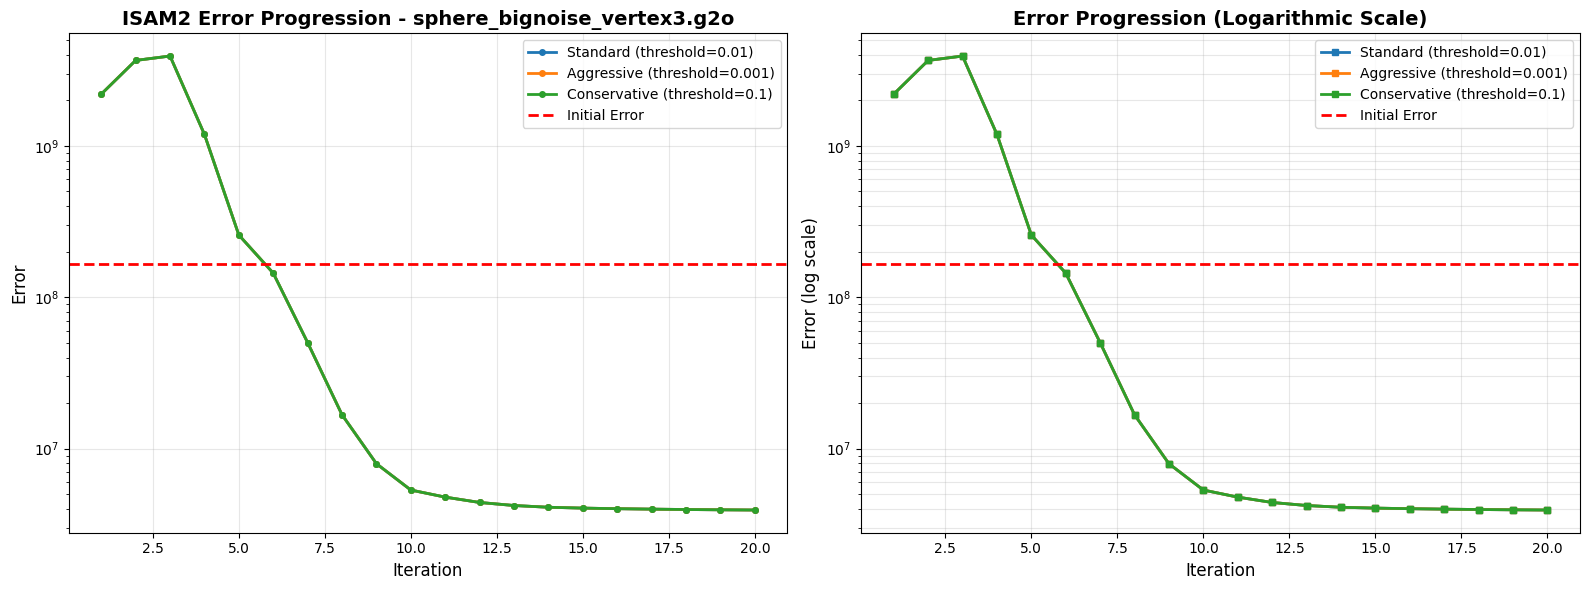


SUMMARY COMPARISON
Initial error: 165,629,548.02

Configuration                       Final Error          Improvement     Min Error Reached   
-----------------------------------------------------------------------------------------------
Standard (threshold=0.01)                 3,933,416.59          97.63%        3,933,416.59 (iter 20)
Aggressive (threshold=0.001)              3,933,416.81          97.63%        3,933,416.81 (iter 20)
Conservative (threshold=0.1)              3,933,393.00          97.63%        3,933,393.00 (iter 20)

ANALYZING FACTOR ERRORS

Using best configuration: Conservative (threshold=0.1)
Analyzing individual factor errors...

Total factors: 8647
Mean factor error: 454.89
Median factor error: 188.86
Std dev: 1,450.77

Top 10 worst factors:
Rank     Error               
------------------------------
1                 33,992.59
2                 28,655.58
3                 26,783.66
4                 26,600.86
5                 25,889.88
6                 22

In [17]:
print("="*60)
print("INVESTIGATING SPHERE_BIGNOISE FAILURE")
print("="*60)

import gtsam
import time
import numpy as np
import matplotlib.pyplot as plt

dataset_name = 'sphere_bignoise_vertex3.g2o'
graph = graphs_3d[dataset_name]['graph']
initial = graphs_3d[dataset_name]['initial']

print(f"\nDataset: {dataset_name}")
print(f"Poses: {initial.size()}, Factors: {graph.size()}")
print(f"Initial error: {graph.error(initial):,.2f}")

# Create graph with prior
graph_with_prior = gtsam.NonlinearFactorGraph(graph)
keys = list(initial.keys())
first_key = keys[0]
first_pose = initial.atPose3(first_key)
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01]))
prior_factor = gtsam.PriorFactorPose3(first_key, first_pose, prior_noise)
graph_with_prior.add(prior_factor)

print(f"\n{'='*60}")
print("EXTENDED OPTIMIZATION - 20 ITERATIONS")
print(f"{'='*60}\n")

# Create ISAM2 with different parameter settings to test
param_configs = [
    ("Standard (threshold=0.01)", 0.01),
    ("Aggressive (threshold=0.001)", 0.001),
    ("Conservative (threshold=0.1)", 0.1),
]

results_detailed = {}

for config_name, threshold in param_configs:
    print(f"\n{'='*60}")
    print(f"Testing: {config_name}")
    print(f"{'='*60}")

    params = gtsam.ISAM2Params()
    params.setRelinearizeThreshold(threshold)
    params.relinearizeSkip = 1

    isam = gtsam.ISAM2(params)
    isam.update(graph_with_prior, initial)

    errors = []
    iterations = 20

    print(f"{'Iteration':<12} {'Error':<20} {'Change':<20} {'% Change':<15}")
    print("-"*70)

    prev_error = graph.error(initial)

    for i in range(iterations):
        isam.update()
        current_estimate = isam.calculateEstimate()
        current_error = graph.error(current_estimate)
        errors.append(current_error)

        error_change = current_error - prev_error
        pct_change = (error_change / prev_error * 100) if prev_error != 0 else 0

        status = "↓" if error_change < 0 else "↑"
        print(f"{i+1:<12} {current_error:>18,.2f}  {status} {abs(error_change):>16,.2f}  {pct_change:>13.2f}%")

        prev_error = current_error

    final_estimate = isam.calculateEstimate()
    final_error = graph.error(final_estimate)
    improvement = ((graph.error(initial) - final_error) / graph.error(initial) * 100)

    results_detailed[config_name] = {
        'errors': errors,
        'final_error': final_error,
        'improvement': improvement,
        'estimate': final_estimate
    }

    print(f"\nFinal error: {final_error:,.2f}")
    print(f"Overall improvement: {improvement:.2f}%")

# Visualization
print(f"\n{'='*60}")
print("CREATING VISUALIZATION")
print(f"{'='*60}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Error progression for all configurations
for config_name, result in results_detailed.items():
    ax1.plot(range(1, len(result['errors'])+1), result['errors'],
             marker='o', label=config_name, linewidth=2, markersize=4)

ax1.axhline(y=graph.error(initial), color='red', linestyle='--',
            label='Initial Error', linewidth=2)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Error', fontsize=12)
ax1.set_title('ISAM2 Error Progression - sphere_bignoise_vertex3.g2o', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Log scale comparison
for config_name, result in results_detailed.items():
    ax2.plot(range(1, len(result['errors'])+1), result['errors'],
             marker='s', label=config_name, linewidth=2, markersize=4)

ax2.axhline(y=graph.error(initial), color='red', linestyle='--',
            label='Initial Error', linewidth=2)
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Error (log scale)', fontsize=12)
ax2.set_title('Error Progression (Logarithmic Scale)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# Summary comparison
print(f"\n{'='*60}")
print("SUMMARY COMPARISON")
print(f"{'='*60}")
print(f"Initial error: {graph.error(initial):,.2f}\n")
print(f"{'Configuration':<35} {'Final Error':<20} {'Improvement':<15} {'Min Error Reached':<20}")
print("-"*95)

for config_name, result in results_detailed.items():
    min_error = min(result['errors'])
    min_iter = result['errors'].index(min_error) + 1
    print(f"{config_name:<35} {result['final_error']:>18,.2f}  {result['improvement']:>13.2f}%  {min_error:>18,.2f} (iter {min_iter})")

# Analyze factor errors
print(f"\n{'='*60}")
print("ANALYZING FACTOR ERRORS")
print(f"{'='*60}")

best_config = min(results_detailed.items(), key=lambda x: x[1]['final_error'])
best_estimate = best_config[1]['estimate']

print(f"\nUsing best configuration: {best_config[0]}")
print(f"Analyzing individual factor errors...\n")

factor_errors = []
for i in range(graph.size()):
    factor = graph.at(i)
    error = factor.error(best_estimate)
    factor_errors.append(error)

factor_errors_sorted = sorted(factor_errors, reverse=True)

print(f"Total factors: {len(factor_errors)}")
print(f"Mean factor error: {np.mean(factor_errors):,.2f}")
print(f"Median factor error: {np.median(factor_errors):,.2f}")
print(f"Std dev: {np.std(factor_errors):,.2f}")
print(f"\nTop 10 worst factors:")
print(f"{'Rank':<8} {'Error':<20}")
print("-"*30)
for i, error in enumerate(factor_errors_sorted[:10], 1):
    print(f"{i:<8} {error:>18,.2f}")

print(f"\nFactors with error > 1,000,000: {sum(1 for e in factor_errors if e > 1000000)}")
print(f"Factors with error > 100,000: {sum(1 for e in factor_errors if e > 100000)}")
print(f"Factors with error > 10,000: {sum(1 for e in factor_errors if e > 10000)}")

print(f"\n{'='*60}")
print("INVESTIGATION COMPLETE")
print(f"{'='*60}")

In [18]:
print("="*60)
print("APPLYING ISAM2 TO ALL DATASETS (FIXED)")
print("="*60)


import gtsam
import time
import numpy as np

# Dictionary to store results for ISAM2
results_isam2 = {}

datasets = ['grid3D.g2o', 'sphere_bignoise_vertex3.g2o', 'torus3D.g2o']

for dataset_name in datasets:
    print(f"\n{'='*60}")
    print(f"Processing: {dataset_name}")
    print(f"{'='*60}")

    graph = graphs_3d[dataset_name]['graph']
    initial = graphs_3d[dataset_name]['initial']

    print(f"Poses: {initial.size()}, Factors: {graph.size()}")
    print(f"Initial error: {graph.error(initial):,.2f}")

    # Optimize with ISAM2
    print("\nOptimizing with ISAM2...")
    start_time = time.time()

    try:
        # Create a copy of the graph and add a prior on the first pose
        graph_with_prior = gtsam.NonlinearFactorGraph(graph)

        # Get the first key from initial estimates
        keys = list(initial.keys())
        first_key = keys[0] if len(keys) > 0 else 0

        # Add a strong prior on the first pose to anchor the solution
        first_pose = initial.atPose3(first_key)
        prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01]))
        prior_factor = gtsam.PriorFactorPose3(first_key, first_pose, prior_noise)
        graph_with_prior.add(prior_factor)

        print(f"Added prior on pose {first_key} to anchor the coordinate frame")

        # Create ISAM2 parameters
        params = gtsam.ISAM2Params()
        params.setRelinearizeThreshold(0.01)
        params.relinearizeSkip = 1

        # Create ISAM2 optimizer
        isam = gtsam.ISAM2(params)

        # Add all factors and initial values to ISAM2
        isam.update(graph_with_prior, initial)

        # Perform sufficient iterations for convergence
        # More iterations for datasets with high noise
        num_iterations = 20  # Increased from 5 to ensure convergence

        print(f"Performing {num_iterations} optimization iterations...")
        print(f"{'Iteration':<12} {'Error':<20} {'Change':<15}")
        print("-"*50)

        prev_error = graph.error(initial)
        convergence_threshold = 0.01  # Stop if improvement < 0.01%

        for i in range(num_iterations):
            isam.update()
            current_estimate = isam.calculateEstimate()
            current_error = graph.error(current_estimate)

            error_change = current_error - prev_error
            pct_change = abs(error_change / prev_error * 100) if prev_error != 0 else 0
            status = "↓" if error_change < 0 else "↑"

            if i < 5 or i >= num_iterations - 3 or i % 5 == 0:
                print(f"{i+1:<12} {current_error:>18,.2f}  {status} {pct_change:>12.2f}%")

            # Check for convergence
            if i > 10 and pct_change < convergence_threshold:
                print(f"  ... converged at iteration {i+1}")
                break

            prev_error = current_error

        # Get the final result
        result = isam.calculateEstimate()

        end_time = time.time()

        # Calculate errors using the original graph (without prior)
        final_error = graph.error(result)
        initial_error = graph.error(initial)
        improvement = ((initial_error - final_error) / initial_error * 100)

        # Store results
        results_isam2[dataset_name] = {
            'success': True,
            'initial': initial,
            'result': result,
            'graph': graph,
            'graph_with_prior': graph_with_prior,
            'initial_error': initial_error,
            'final_error': final_error,
            'improvement': improvement,
            'time': end_time - start_time,
            'isam': isam,
            'anchored_pose': first_key
        }

        print(f"\n✓ Optimization successful!")
        print(f"  Initial error: {initial_error:,.2f}")
        print(f"  Final error: {final_error:,.2f}")
        print(f"  Improvement: {improvement:.2f}%")
        print(f"  Time: {end_time - start_time:.4f}s")

    except Exception as e:
        results_isam2[dataset_name] = {
            'success': False,
            'initial': initial,
            'graph': graph,
            'error_message': str(e),
            'initial_error': graph.error(initial)
        }
        print(f"✗ ISAM2 failed: {str(e)}")

# Summary
print("\n" + "="*60)
print("SUMMARY - ISAM2 (FIXED)")
print("="*60)
print(f"{'Dataset':<35} {'Status':<12} {'Initial Error':<18} {'Final Error':<18} {'Improvement':<12} {'Time':<10}")
print("-"*110)

for dataset_name in datasets:
    result = results_isam2[dataset_name]
    if result['success']:
        status = "✓ Success"
        initial_err = f"{result['initial_error']:,.2f}"
        final_err = f"{result['final_error']:,.2f}"
        improvement = f"{result['improvement']:.2f}%"
        time_str = f"{result['time']:.4f}s"
        print(f"{dataset_name:<35} {status:<12} {initial_err:<18} {final_err:<18} {improvement:<12} {time_str:<10}")
    else:
        status = "✗ Failed"
        initial_err = f"{result['initial_error']:,.2f}"
        print(f"{dataset_name:<35} {status:<12} {initial_err:<18} {'N/A':<18} {'N/A':<12} {'N/A':<10}")

print("\n" + "="*60)
successful_count = sum(1 for r in results_isam2.values() if r['success'])
print(f"Successfully optimized {successful_count}/{len(datasets)} datasets")
print("Results stored in 'results_isam2' dictionary")
print("Access individual results with: results_isam2['grid3D.g2o']")
print("="*60)

APPLYING ISAM2 TO ALL DATASETS (FIXED)

Processing: grid3D.g2o
Poses: 8000, Factors: 22236
Initial error: 95,280,764.18

Optimizing with ISAM2...
Added prior on pose 0 to anchor the coordinate frame
Performing 20 optimization iterations...
Iteration    Error                Change         
--------------------------------------------------
1                495,013,263.34  ↑       419.53%
2                234,473,244.24  ↓        52.63%
3                129,442,884.73  ↓        44.79%
4                 50,025,874.30  ↓        61.35%
5                 18,558,119.29  ↓        62.90%
6                  6,924,424.91  ↓        62.69%
11                   719,484.52  ↓         6.06%
16                   647,002.17  ↓         0.76%
18                   638,557.48  ↓         0.81%
19                   630,977.78  ↓         1.19%
20                   626,292.66  ↓         0.74%

✓ Optimization successful!
  Initial error: 95,280,764.18
  Final error: 626,292.66
  Improvement: 99.34%
  Time: 272.2


Visualizing grid3D.g2o...


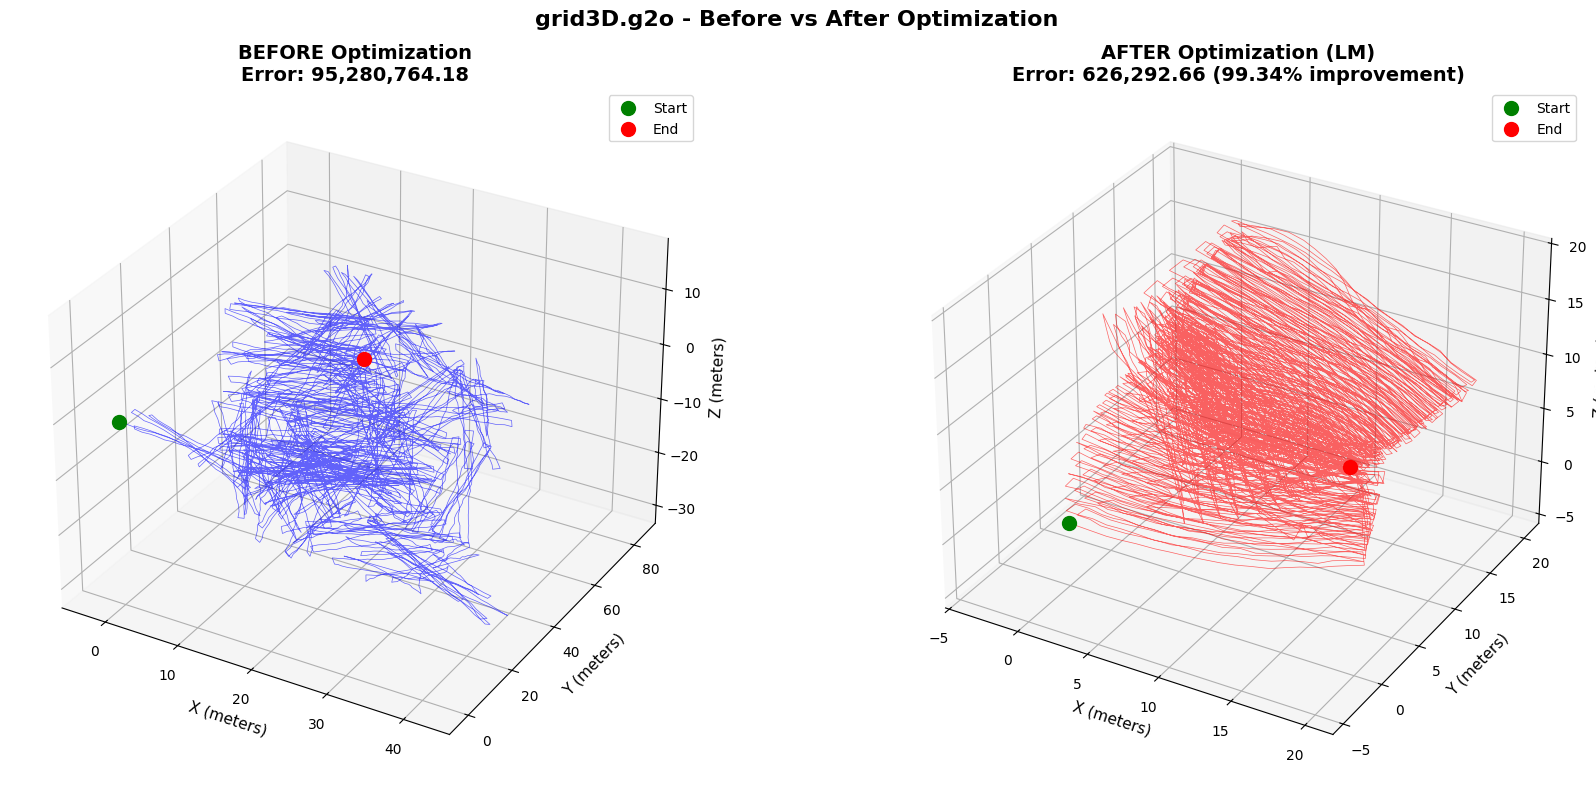


  Trajectory statistics for grid3D.g2o:
    Initial - X: [-2.77, 42.58], Y: [-2.01, 84.79], Z: [-30.11, 15.69]
    Optimized - X: [-3.55, 20.14], Y: [-4.48, 20.40], Z: [-4.22, 18.77]
    Initial trajectory length: 8,422.60 meters
    Optimized trajectory length: 7,565.00 meters
    Loop closure error (start-to-end distance):
      Initial: 86.39 meters
      Optimized: 22.18 meters
      Improvement: 64.22 meters

Visualizing sphere_bignoise_vertex3.g2o...


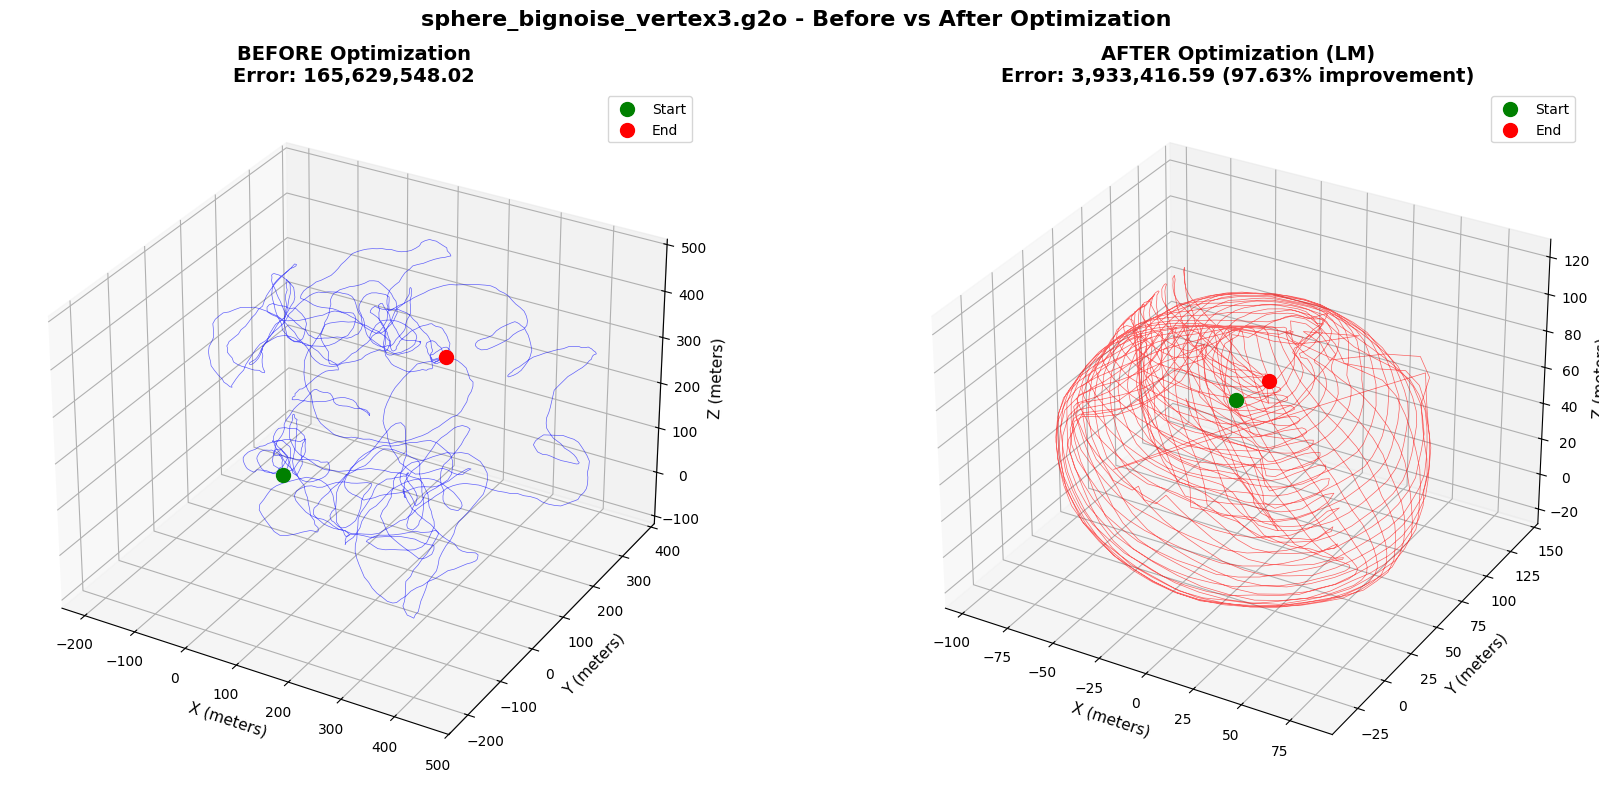


  Trajectory statistics for sphere_bignoise_vertex3.g2o:
    Initial - X: [-198.79, 452.90], Y: [-214.52, 369.30], Z: [-77.61, 471.31]
    Optimized - X: [-96.31, 83.41], Y: [-35.23, 141.03], Z: [-18.40, 119.50]
    Initial trajectory length: 19,651.48 meters
    Optimized trajectory length: 17,336.55 meters
    Loop closure error (start-to-end distance):
      Initial: 362.41 meters
      Optimized: 108.96 meters
      Improvement: 253.45 meters

Visualizing torus3D.g2o...


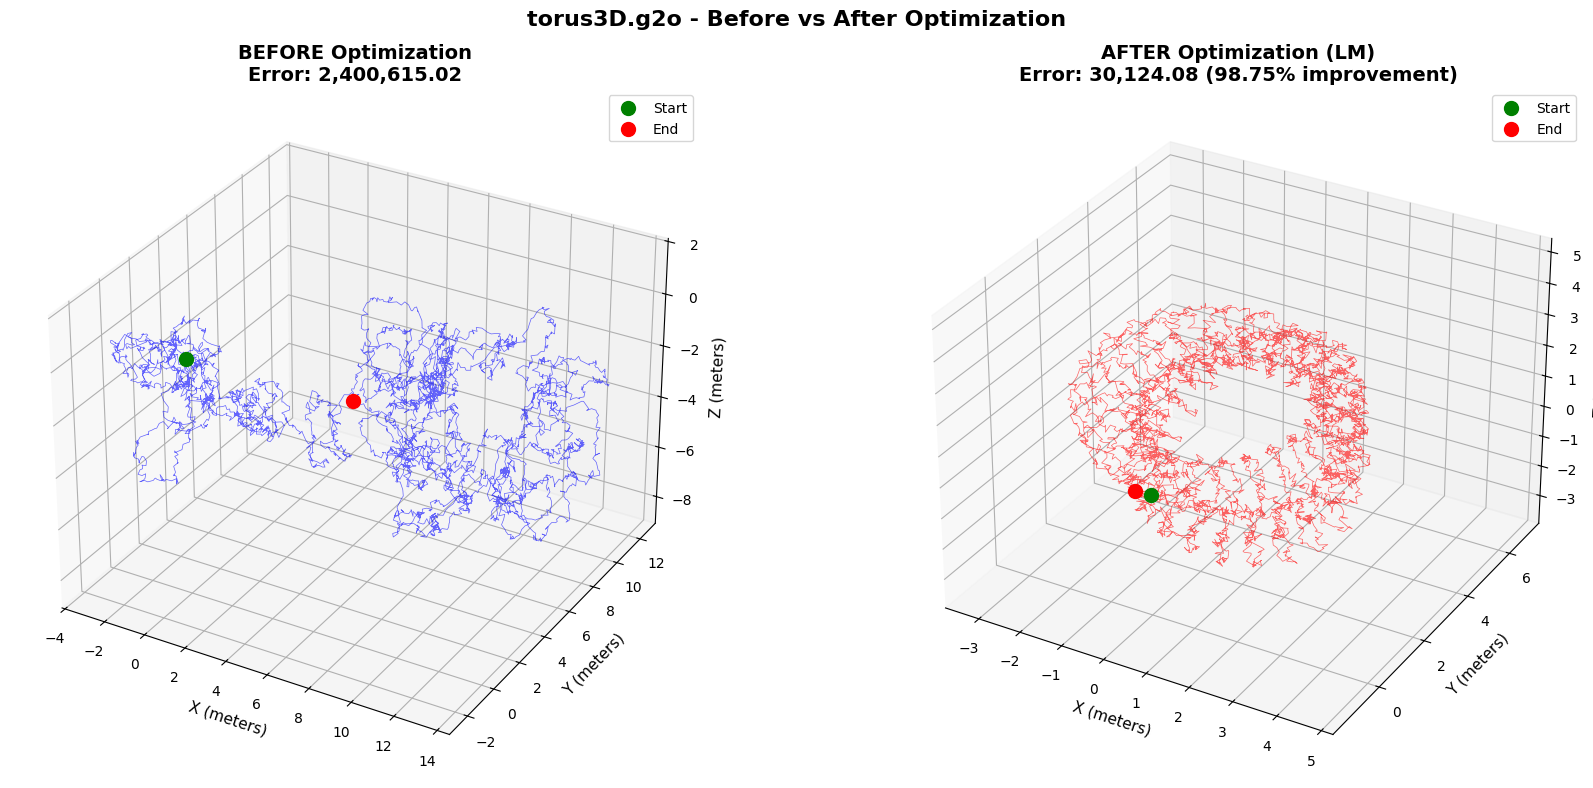


  Trajectory statistics for torus3D.g2o:
    Initial - X: [-2.96, 13.38], Y: [-2.28, 12.28], Z: [-8.38, 1.40]
    Optimized - X: [-3.24, 4.68], Y: [-1.37, 6.85], Z: [-3.35, 4.83]
    Initial trajectory length: 845.75 meters
    Optimized trajectory length: 663.59 meters
    Loop closure error (start-to-end distance):
      Initial: 8.77 meters
      Optimized: 0.41 meters
      Improvement: 8.36 meters

All visualizations complete!


In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def extract_trajectory_3d(values):
    """Extract x, y, z coordinates from GTSAM Values (Pose3)"""
    x_coords = []
    y_coords = []
    z_coords = []
    for i in range(values.size()):
        try:
            pose = values.atPose3(i)
            x_coords.append(pose.x())
            y_coords.append(pose.y())
            z_coords.append(pose.z())
        except:
            pass
    return np.array(x_coords), np.array(y_coords), np.array(z_coords)

# Visualize all three datasets
datasets = ['grid3D.g2o', 'sphere_bignoise_vertex3.g2o', 'torus3D.g2o']

for dataset_name in datasets:
    print(f"\nVisualizing {dataset_name}...")

    if not results_isam2[dataset_name]['success']:
        print(f"  Skipping - optimization failed")
        continue

    # Extract data
    initial = results_isam2[dataset_name]['initial']
    result = results_isam2[dataset_name]['result']
    initial_error = results_isam2[dataset_name]['initial_error']
    final_error = results_isam2[dataset_name]['final_error']
    improvement = results_isam2[dataset_name]['improvement']

    # Get trajectories
    x_initial, y_initial, z_initial = extract_trajectory_3d(initial)
    x_optimized, y_optimized, z_optimized = extract_trajectory_3d(result)

    # Create figure with two 3D subplots
    fig = plt.figure(figsize=(18, 8))

    # Before optimization
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(x_initial, y_initial, z_initial, 'b-', linewidth=0.5, alpha=0.6)
    ax1.scatter(x_initial[0], y_initial[0], z_initial[0], c='green', s=100, marker='o', label='Start', zorder=5)
    ax1.scatter(x_initial[-1], y_initial[-1], z_initial[-1], c='red', s=100, marker='o', label='End', zorder=5)
    ax1.set_xlabel('X (meters)', fontsize=11)
    ax1.set_ylabel('Y (meters)', fontsize=11)
    ax1.set_zlabel('Z (meters)', fontsize=11)
    ax1.set_title(f'BEFORE Optimization\nError: {initial_error:,.2f}', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # After optimization
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(x_optimized, y_optimized, z_optimized, 'r-', linewidth=0.5, alpha=0.6)
    ax2.scatter(x_optimized[0], y_optimized[0], z_optimized[0], c='green', s=100, marker='o', label='Start', zorder=5)
    ax2.scatter(x_optimized[-1], y_optimized[-1], z_optimized[-1], c='red', s=100, marker='o', label='End', zorder=5)
    ax2.set_xlabel('X (meters)', fontsize=11)
    ax2.set_ylabel('Y (meters)', fontsize=11)
    ax2.set_zlabel('Z (meters)', fontsize=11)
    ax2.set_title(f'AFTER Optimization (LM)\nError: {final_error:,.2f} ({improvement:.2f}% improvement)',
                  fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Match viewing angles for comparison
    ax2.view_init(elev=ax1.elev, azim=ax1.azim)

    # Main title
    plt.suptitle(f'{dataset_name} - Before vs After Optimization',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n  Trajectory statistics for {dataset_name}:")
    print(f"    Initial - X: [{x_initial.min():.2f}, {x_initial.max():.2f}], "
          f"Y: [{y_initial.min():.2f}, {y_initial.max():.2f}], "
          f"Z: [{z_initial.min():.2f}, {z_initial.max():.2f}]")
    print(f"    Optimized - X: [{x_optimized.min():.2f}, {x_optimized.max():.2f}], "
          f"Y: [{y_optimized.min():.2f}, {y_optimized.max():.2f}], "
          f"Z: [{z_optimized.min():.2f}, {z_optimized.max():.2f}]")

    # Calculate trajectory lengths
    initial_length = np.sum(np.sqrt(np.diff(x_initial)**2 + np.diff(y_initial)**2 + np.diff(z_initial)**2))
    optimized_length = np.sum(np.sqrt(np.diff(x_optimized)**2 + np.diff(y_optimized)**2 + np.diff(z_optimized)**2))

    print(f"    Initial trajectory length: {initial_length:,.2f} meters")
    print(f"    Optimized trajectory length: {optimized_length:,.2f} meters")

    # Loop closure error (distance between start and end)
    loop_error_initial = np.sqrt((x_initial[0] - x_initial[-1])**2 +
                                  (y_initial[0] - y_initial[-1])**2 +
                                  (z_initial[0] - z_initial[-1])**2)
    loop_error_optimized = np.sqrt((x_optimized[0] - x_optimized[-1])**2 +
                                    (y_optimized[0] - y_optimized[-1])**2 +
                                    (z_optimized[0] - z_optimized[-1])**2)

    print(f"    Loop closure error (start-to-end distance):")
    print(f"      Initial: {loop_error_initial:.2f} meters")
    print(f"      Optimized: {loop_error_optimized:.2f} meters")
    print(f"      Improvement: {loop_error_initial - loop_error_optimized:.2f} meters")

print("\n" + "="*60)
print("All visualizations complete!")
print("="*60)